In [ ]:
# Import all the required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [ ]:
# Parameters
img_height, img_width, img_channel = 28, 28, 1
n_batch = 128
n_epoch = 100
latent_dim = 2

In [ ]:
# Import dataset MNIST-Fashion dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist = np.concatenate([x_train, x_test], axis=0)
mnist = np.expand_dims(mnist, -1).astype("float32") / 255

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(type(mnist))

<class 'numpy.ndarray'>


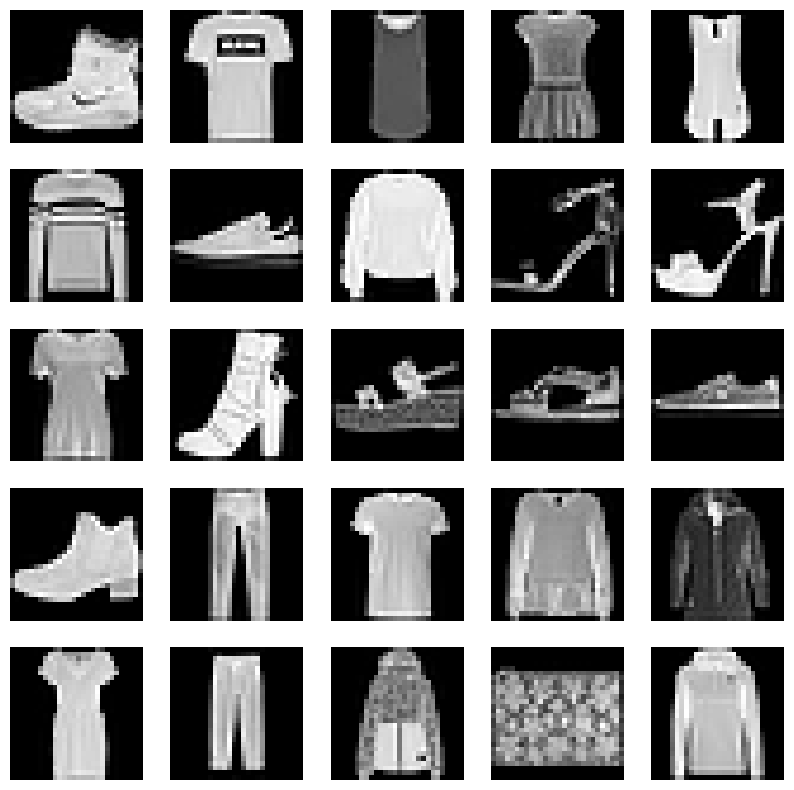

In [ ]:
# Visualize our data
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(mnist[i], cmap ='gray')
    plt.axis("off")

####To define the VAE function, we should keep in mind different components of the encoder, reparameterization/sampling layer and decoder are defined separately and in sequence.

####The loss function is defined as the summation of reconstruction_loss plus the kl_loss as explained in the theory section.

In [ ]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        # encoder
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(img_height, img_width, img_channel)),
            Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            Flatten(),
            Dense(16, activation="relu"),
            Dense(latent_dim),
        ])

        # reparameterization/sampling layer
        self.z_mean = Dense(latent_dim, name="z_mean")
        self.z_log_var = Dense(latent_dim, name="z_log_var")

        # decoder
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation="relu"),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
        ])

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var

    # Build the reparameterization/sampling layer
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z

    # Build the decoder
    def decode(self, data):
        return self.decoder(data)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Train the VAE
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist, epochs= n_epoch, batch_size= n_batch)

Epoch 1/100
547/547 [==============================] - 18s 9ms/step - loss: 390.8031 - reconstruction_loss: 333.0862 - kl_loss: 5.5992
Epoch 2/100
547/547 [==============================] - 4s 8ms/step - loss: 284.4357 - reconstruction_loss: 274.1662 - kl_loss: 7.4766
Epoch 3/100
547/547 [==============================] - 5s 8ms/step - loss: 277.3163 - reconstruction_loss: 268.8436 - kl_loss: 7.2061
Epoch 4/100
547/547 [==============================] - 4s 8ms/step - loss: 273.8426 - reconstruction_loss: 266.2346 - kl_loss: 7.1039
Epoch 5/100
547/547 [==============================] - 4s 8ms/step - loss: 272.0720 - reconstruction_loss: 264.5077 - kl_loss: 7.0629
Epoch 6/100
547/547 [==============================] - 5s 8ms/step - loss: 269.9890 - reconstruction_loss: 263.2597 - kl_loss: 7.0478
Epoch 7/100
547/547 [==============================] - 4s 8ms/step - loss: 269.3831 - reconstruction_loss: 262.2712 - kl_loss: 7.0151
Epoch 8/100
547/547 [==============================] - 4s 8ms

#### To generate new images similar to Fashion MNIST dataset, we only need to provide a pair of (μ, σ) values to the decoder.

In [ ]:
print(vae)

1/1 [==============================] - 0s 18ms/step


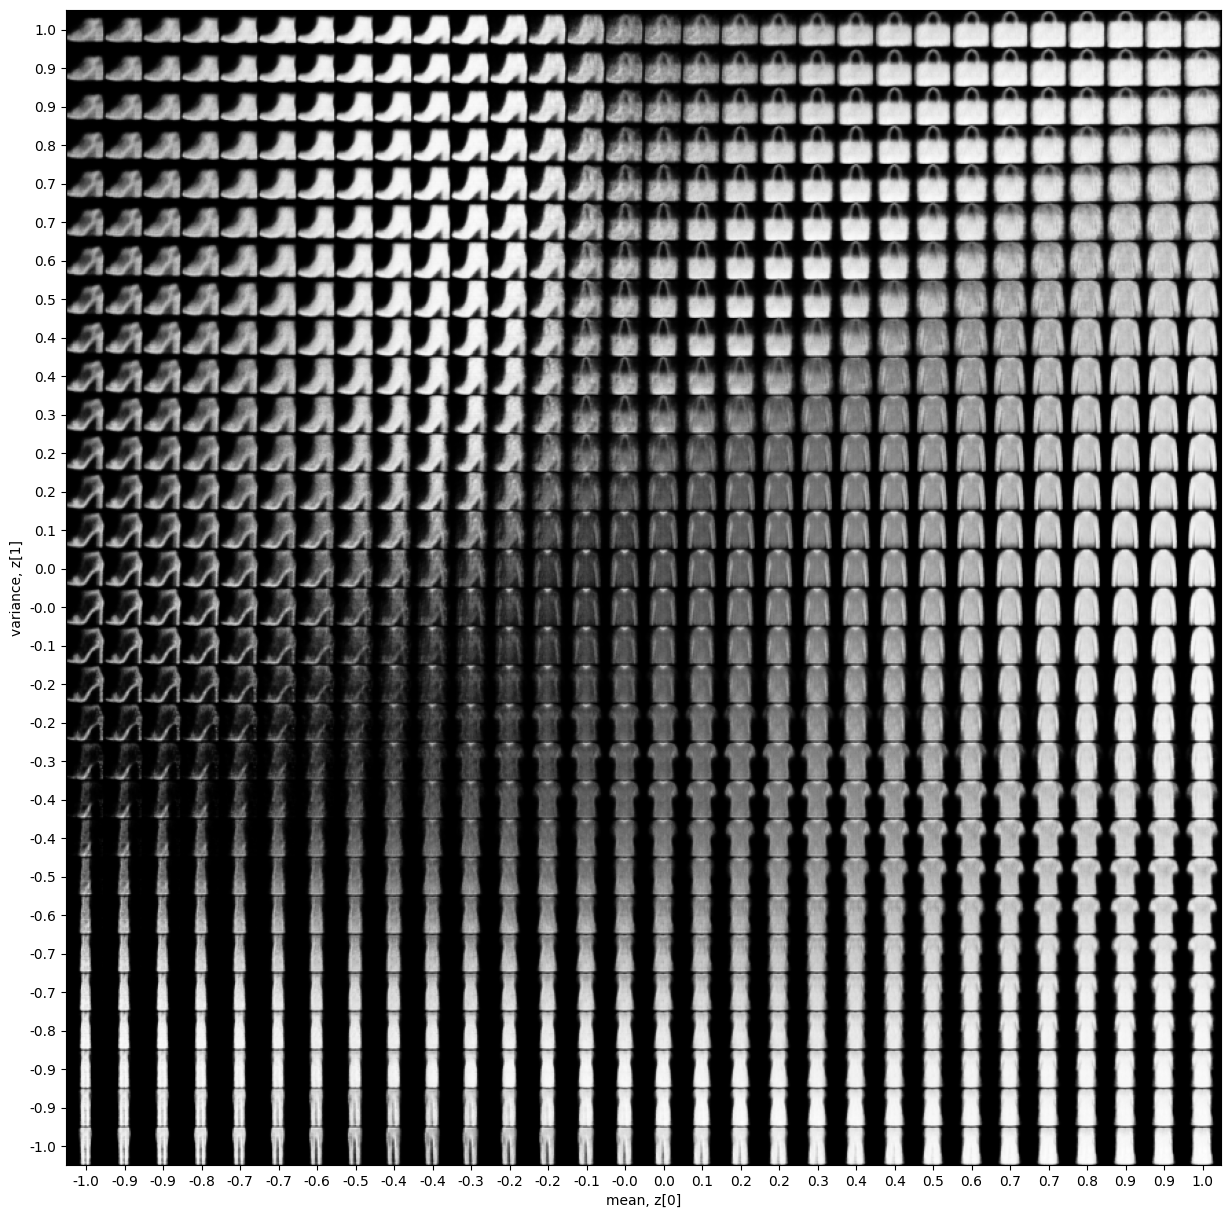

In [ ]:
# Display a grid of sampled classes
def plot_latent_space(vae, n=30, figsize=15):
    img_height = 28
    scale = 1.0
    figure = np.zeros((img_height * n, img_height * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            classes = x_decoded[0].reshape(img_height, img_height)
            figure[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
            ] = classes

    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("variance, z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)